# LightFM RecSys Modeling

## Setup

In [ ]:
!pip install lightfm

In [ ]:
import numpy as np

from lightfm import LightFM
from lightfm.datasets import fetch_stackexchange
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

## Item cold-start: recommending StackExchange questions

In this example we'll use the StackExchange dataset to explore recommendations under item-cold start. Data dumps from the StackExchange network are available at https://archive.org/details/stackexchange, and we'll use one of them --- for stats.stackexchange.com --- here.

The consists of users answering questions: in the user-item interaction matrix, each user is a row, and each question is a column. Based on which users answered which questions in the training set, we'll try to recommend new questions in the training set.

Let's start by loading the data. We'll use the `datasets` module.

In [ ]:
data = fetch_stackexchange('crossvalidated',
                           test_set_fraction=0.1,
                           indicator_features=False,
                           tag_features=True)

train = data['train']
test = data['test']

Let's examine the data:

In [ ]:
print('The dataset has %s users and %s items, '
      'with %s interactions in the test and %s interactions in the training set.'
      % (train.shape[0], train.shape[1], test.getnnz(), train.getnnz()))

The dataset has 3213 users and 72360 items, with 4453 interactions in the test and 57795 interactions in the training set.


The training and test set are divided chronologically: the test set contains the 10% of interactions that happened after the 90% in the training set. This means that many of the questions in the test set have no interactions. This is an accurate description of a questions answering system: it is most important to recommend questions that have not yet been answered to the expert users who can answer them.

### A pure collaborative filtering model

This is clearly a cold-start scenario, and so we can expect a traditional collaborative filtering model to do very poorly. Let's check if that's the case:

In [ ]:
# Set the number of threads; you can increase this
# ify you have more physical cores available.
NUM_THREADS = 2
NUM_COMPONENTS = 30
NUM_EPOCHS = 3
ITEM_ALPHA = 1e-6

# Let's fit a WARP model: these generally have the best performance.
model = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Run 3 epochs and time it.
%time model = model.fit(train, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

CPU times: user 656 ms, sys: 7.28 ms, total: 663 ms
Wall time: 364 ms


As a means of sanity checking, let's calculate the model's AUC on the training set first. If it's reasonably high, we can be sure that the model is not doing anything stupid and is fitting the training data well.

In [ ]:
# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.889321


Fantastic, the model is fitting the training set well. But what about the test set?

In [ ]:
# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.
test_auc = auc_score(model, test, train_interactions=train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.354165


This is terrible: we do worse than random! This is not very surprising: as there is no training data for the majority of the test questions, the model cannot compute reasonable representations of the test set items. 

The fact that we score them lower than other items (AUC < 0.5) is due to estimated per-item biases, which can be confirmed by setting them to zero and re-evaluating the model.

In [ ]:
# Set biases to zero
model.item_biases *= 0.0

test_auc = auc_score(model, test, train_interactions=train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.508637


### A hybrid model

We can do much better by employing LightFM's hybrid model capabilities. The StackExchange data comes with content information in the form of tags users apply to their questions:

In [ ]:
item_features = data['item_features']
tag_labels = data['item_feature_labels']

print('There are %s distinct tags, with values like %s.' % (item_features.shape[1], tag_labels[:3].tolist()))

There are 1246 distinct tags, with values like ['bayesian', 'prior', 'elicitation'].


In [ ]:
item_features

<72360x1246 sparse matrix of type '<class 'numpy.float32'>'
	with 198963 stored elements in Compressed Sparse Row format>

In [ ]:
train

<3221x72360 sparse matrix of type '<class 'numpy.float32'>'
	with 57830 stored elements in COOrdinate format>

We can use these features (instead of an identity feature matrix like in a pure CF model) to estimate a model which will generalize better to unseen examples: it will simply use its representations of item features to infer representations of previously unseen questions.

Let's go ahead and fit a model of this type.

In [ ]:
# Define a new model instance
model = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
                no_components=NUM_COMPONENTS)

# Fit the hybrid model. Note that this time, we pass
# in the item features matrix.
model = model.fit(train,
                item_features=item_features,
                epochs=NUM_EPOCHS,
                num_threads=NUM_THREADS)

As before, let's sanity check the model on the training set.

In [ ]:
# Don't forget the pass in the item features again!
train_auc = auc_score(model,
                      train,
                      item_features=item_features,
                      num_threads=NUM_THREADS).mean()
print('Hybrid training set AUC: %s' % train_auc)

Hybrid training set AUC: 0.848155


Note that the training set AUC is lower than in a pure CF model. This is fine: by using a lower-rank item feature matrix, we have effectively regularized the model, giving it less freedom to fit the training data.

Despite this the model does much better on the test set:

In [ ]:
test_auc = auc_score(model,
                    test,
                    train_interactions=train,
                    item_features=item_features,
                    num_threads=NUM_THREADS).mean()
print('Hybrid test set AUC: %s' % test_auc)

Hybrid test set AUC: 0.702735


This is as expected: because items in the test set share tags with items in the training set, we can provide better test set recommendations by using the tag representations learned from training.

### Bonus: tag embeddings

One of the nice properties of the hybrid model is that the estimated tag embeddings capture semantic characteristics of the tags. Like the word2vec model, we can use this property to explore semantic tag similarity:

In [ ]:
def get_similar_tags(model, tag_id):
    # Define similarity as the cosine of the angle
    # between the tag latent vectors
    
    # Normalize the vectors to unit length
    tag_embeddings = (model.item_embeddings.T
                      / np.linalg.norm(model.item_embeddings, axis=1)).T
    
    query_embedding = tag_embeddings[tag_id]
    similarity = np.dot(tag_embeddings, query_embedding)
    most_similar = np.argsort(-similarity)[1:4]
    
    return most_similar


for tag in (u'bayesian', u'regression', u'survival'):
    tag_id = tag_labels.tolist().index(tag)
    print('Most similar tags for %s: %s' % (tag_labels[tag_id],
                                            tag_labels[get_similar_tags(model, tag_id)]))

Most similar tags for bayesian: ['mcmc' 'prior' 'r-project']
Most similar tags for regression: ['multiple-regression' 'explanatory-models' 'bic']
Most similar tags for survival: ['cox-model' 'kaplan-meier' 'epidemiology']


## LightFM ML-100k

In this example, we'll build an implicit feedback recommender using the Movielens 100k dataset (http://grouplens.org/datasets/movielens/100k/).

The code behind this example is available as a [Jupyter notebook](https://github.com/lyst/lightfm/tree/master/examples/quickstart/quickstart.ipynb)

LightFM includes functions for getting and processing this dataset, so obtaining it is quite easy.

In [ ]:
data = fetch_movielens(min_rating=5.0)

In [ ]:
data

{'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 2153 stored elements in COOrdinate format>,
 'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 19048 stored elements in COOrdinate format>}

This downloads the dataset and automatically pre-processes it into sparse matrices suitable for further calculation. In particular, it prepares the sparse user-item matrices, containing positive entries where a user interacted with a product, and zeros otherwise.

We have two such matrices, a training and a testing set. Both have around 1000 users and 1700 items. We'll train the model on the train matrix but test it on the test matrix.

In [ ]:
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 19048 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 2153 stored elements in COOrdinate format>


We're going to use the WARP (Weighted Approximate-Rank Pairwise) model. WARP is an implicit feedback model: all interactions in the training matrix are treated as positive signals, and products that users did not interact with they implicitly do not like. The goal of the model is to score these implicit positives highly while assigining low scores to implicit negatives.

Model training is accomplished via SGD (stochastic gradient descent). This means that for every pass through the data --- an epoch --- the model learns to fit the data more and more closely. We'll run it for 10 epochs in this example. We can also run it on multiple cores, so we'll set that to 2. (The dataset in this example is too small for that to make a difference, but it will matter on bigger datasets.)

In [ ]:
model = LightFM(loss='warp')
%time model.fit(data['train'], epochs=30, num_threads=2)

CPU times: user 448 ms, sys: 4 ms, total: 452 ms
Wall time: 284 ms


Done! We should now evaluate the model to see how well it's doing. We're most interested in how good the ranking produced by the model is. Precision@k is one suitable metric, expressing the percentage of top k items in the ranking the user has actually interacted with. `lightfm` implements a number of metrics in the `evaluation` module. 

In [ ]:
from lightfm.evaluation import precision_at_k

We'll measure precision in both the train and the test set.

In [ ]:
print("Train precision: %.2f" % precision_at_k(model, data['train'], k=5).mean())
print("Test precision: %.2f" % precision_at_k(model, data['test'], k=5).mean())

Train precision: 0.39
Test precision: 0.05


Unsurprisingly, the model fits the train set better than the test set.

For an alternative way of judging the model, we can sample a couple of users and get their recommendations. To make predictions for given user, we pass the id of that user and the ids of all products we want predictions for into the `predict` method.

In [ ]:
def sample_recommendation(model, data, user_ids):
    

    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        
        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)
        
sample_recommendation(model, data, [3, 25, 450]) 

User 3
     Known positives:
        Contact (1997)
        Air Force One (1997)
        In & Out (1997)
     Recommended:
        Air Force One (1997)
        Saint, The (1997)
        Chasing Amy (1997)
User 25
     Known positives:
        Fargo (1996)
        Godfather, The (1972)
        L.A. Confidential (1997)
     Recommended:
        L.A. Confidential (1997)
        Fargo (1996)
        Titanic (1997)
User 450
     Known positives:
        Event Horizon (1997)
        Scream (1996)
        Conspiracy Theory (1997)
     Recommended:
        Air Force One (1997)
        Ransom (1996)
        Twister (1996)


**To sum up**

In [ ]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
train_precision = precision_at_k(model, data['train'], k=5).mean()
test_precision = precision_at_k(model, data['test'], k=5).mean()

print("Train precision WARP: {:.2f}".format(train_precision))
print("Test precision WARP: {:.2f}".format(test_precision))

Train precision WARP: 0.43
Test precision WARP: 0.05


In [ ]:
# Instantiate and train the model
model = LightFM(loss='bpr')
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
train_precision = precision_at_k(model, data['train'], k=5).mean()
test_precision = precision_at_k(model, data['test'], k=5).mean()

print("Train precision BPR: {:.2f}".format(train_precision))
print("Test precision BPR: {:.2f}".format(test_precision))

Train precision BPR: 0.46
Test precision BPR: 0.04


## Implicit feedback recommender for the Movielens dataset with LightFM

The following notebook is available at [LightFM Github repo](https://github.com/lyst/lightfm)


### Implicit feedback
For some time, the recommender system literature focused on explicit feedback: the Netflix prize focused on accurately reproducing the ratings users have given to movies they watched.

Focusing on ratings in this way ignored the importance of taking into account which movies the users chose to watch in the first place, and treating the absence of ratings as absence of information.

But the things that we don't have ratings for aren't unknowns: we know the user didn't pick them. This reflects a user's conscious choice, and is a good source of information on what she thinks she might like. 

This sort of phenomenon is described as data which is missing-not-at-random in the literature: the ratings that are missing are more likely to be negative precisely because the user chooses which items to rate. When choosing a restaurant, you only go to places which you think you'll enjoy, and never go to places that you think you'll hate. What this leads to is that you're only going to be submitting ratings for things which, a priori, you expected to like; the things that you expect you will not like you will never rate.

This observation has led to the development of models that are suitable for implicit feedback. LightFM implements two that have proven particular successful:

- BPR: Bayesian Personalised Ranking [1] pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise [2] loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.

This example shows how to estimate these models on the Movielens dataset.

[1] Rendle, Steffen, et al. "BPR: Bayesian personalized ranking from implicit feedback." Proceedings of the Twenty-Fifth Conference on Uncertainty in Artificial Intelligence. AUAI Press, 2009.

[2] Weston, Jason, Samy Bengio, and Nicolas Usunier. "Wsabie: Scaling up to large vocabulary image annotation." IJCAI. Vol. 11. 2011.

### Getting the data
The first step is to get the [Movielens data](http://grouplens.org/datasets/movielens/100k/). This is a classic small recommender dataset, consisting of around 950 users, 1700 movies, and 100,000 ratings. The ratings are on a scale from 1 to 5, but we'll all treat them as implicit positive feedback in this example.


Fortunately, this is one of the functions provided by LightFM itself.

In [ ]:
import numpy as np

from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

This gives us a dictionary with the following fields:

In [ ]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

('test', <class 'scipy.sparse.coo.coo_matrix'>, (943, 1682))
('item_features', <class 'scipy.sparse.csr.csr_matrix'>, (1682, 1682))
('train', <class 'scipy.sparse.coo.coo_matrix'>, (943, 1682))
('item_labels', <type 'numpy.ndarray'>, (1682,))
('item_feature_labels', <type 'numpy.ndarray'>, (1682,))


In [ ]:
train = movielens['train']
test = movielens['test']

The `train` and `test` elements are the most important: they contain the raw rating data, split into a train and a test set. Each row represents a user, and each column an item. Entries are ratings from 1 to 5.

### Fitting models

Now let's train a BPR model and look at its accuracy.

We'll use two metrics of accuracy: precision@k and ROC AUC. Both are ranking metrics: to compute them, we'll be constructing recommendation lists for all of our users, and checking the ranking of known positive movies. For precision at k we'll be looking at whether they are within the first k results on the list; for AUC, we'll be calculating the probability that any known positive is higher on the list than a random negative example.

In [ ]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.59, test 0.10.
AUC: train 0.90, test 0.86.


The WARP model, on the other hand, optimises for precision@k---we should expect its performance to be better on precision.

In [ ]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.61, test 0.11.
AUC: train 0.93, test 0.90.


And that is exactly what we see: we get slightly higher precision@10 (but the AUC metric is also improved).

## Using different learning schedules with LightFM

The following notebook is available at [LightFM Github repo](https://github.com/lyst/lightfm)

`lightfm` implements two learning schedules: adagrad and adadelta. Neither is clearly superior, and, like other hyperparameter choices, the best learning schedule will differ based on the problem at hand.

This example tries both at the Movielens 100k dataset.

### Preliminaries
Let's first get the data and define the evaluations functions.

In [ ]:
import numpy as np
import data

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

train, test = movielens['train'], movielens['test']

### Experiment
To evaluate the performance of both learning schedules, let's create two models and run each for a number of epochs, measuring the ROC AUC on the test set at the end of each epoch.

In [ ]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())
    
    
adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

It looks like the adadelta gets to a better result at the beginning of training. However, as we keep running more epochs adagrad wins out, converging to a better final solution.

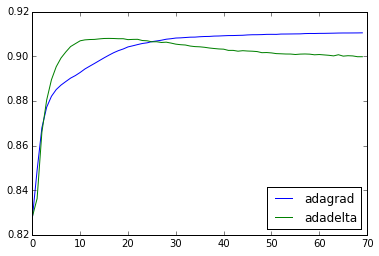

In [ ]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

We can try the same for the k-OS loss.

In [ ]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=alpha, item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())
    
    
adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

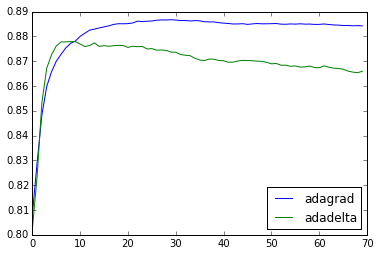

In [ ]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

## Learning-to-rank using the WARP loss

LightFM is probably the only recommender package implementing the WARP (Weighted Approximate-Rank Pairwise) loss for implicit feedback learning-to-rank. Generally, it perfoms better than the more popular BPR (Bayesian Personalised Ranking) loss --- often by a large margin.

It was originally applied to image annotations in the Weston et al. [WSABIE paper](http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf), but has been extended to apply to recommendation settings in the [2013 k-order statistic loss paper](http://www.ee.columbia.edu/~ronw/pubs/recsys2013-kaos.pdf) in the form of the k-OS WARP loss, also implemented in LightFM.

Like the BPR model, WARP deals with (user, positive item, negative item) triplets. Unlike BPR, the negative items in the triplet are not chosen by random sampling: they are chosen from among those negatie items which would violate the desired item ranking given the state of the model. This approximates a form of active learning where the model selects those triplets that it cannot currently rank correctly.

This procedure yields roughly the following algorithm:

1. For a given (user, positive item pair), sample a negative item at random from all the remaining items. Compute predictions for both items; if the negative item's prediction exceeds that of the positive item plus a margin, perform a gradient update to rank the positive item higher and the negative item lower. If there is no rank violation, continue sampling negative items until a violation is found.
2. If you found a violating negative example at the first try, make a large gradient update: this indicates that a lot of negative items are ranked higher than positives items given the current state of the model, and the model must be updated by a large amount. If it took a lot of sampling to find a violating example, perform a small update: the model is likely close to the optimum and should be updated at a low rate.

While this is fairly hand-wavy, it should give the correct intuition. For more details, read the paper itself or a more in-depth blog post [here](https://building-babylon.net/2016/03/18/warp-loss-for-implicit-feedback-recommendation/). A similar approach for BPR is described in Rendle's 2014 [WSDM 2014 paper](http://webia.lip6.fr/~gallinar/gallinari/uploads/Teaching/WSDM2014-rendle.pdf).

Having covered the theory, the rest of this example looks at the practical implications of using WARP in LightFM.

### Preliminaries
Let's first get the data. We'll use the MovieLens 100K dataset.

In [ ]:
import time

import numpy as np

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

train, test = movielens['train'], movielens['test']

### Accuracy
The first interesting experiment is to compare the accuracy between the WARP and BPR losses. Let's fit two models with equivalent hyperparameters and compare their accuracy across epochs. Whilst we're fitting them, let's also measure how much time each epoch takes.

In [ ]:
alpha = 1e-05
epochs = 70
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())
    
for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

Plotting the results immediately reveals that WARP produces superior results: a smarter way of selecting negative examples leads to higher quality rankings. Test accuracy decreases after the first 10 epochs, suggesting WARP starts overfitting and would benefit from regularization or early stopping.

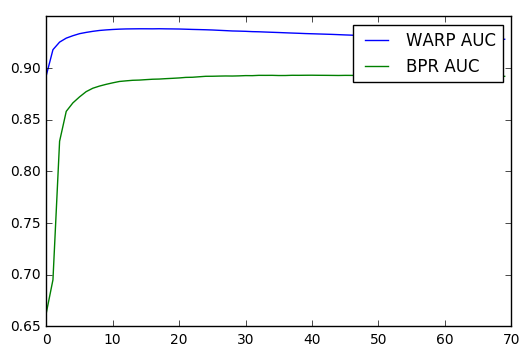

In [ ]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

### Fitting speed

What about model fitting speed?

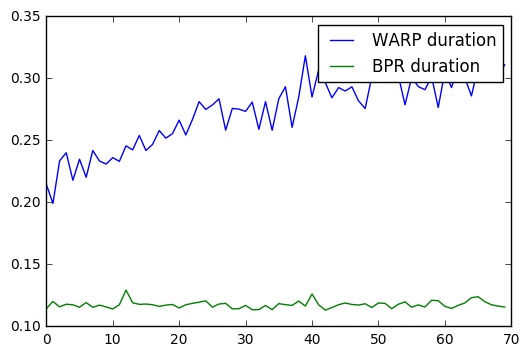

In [ ]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

WARP is slower than BPR for all epochs. Interestingly, however, it gets slower with additional epochs; every subsequent epoch takes more time. This is because of WARP's adaptive samling of negatives: the closer the model fits the training data, the more times it needs to sample in order to find rank-violating examples, leading to longer fitting times.

For this reason, LightFM exposes the `max_sampled` hyperparameter that limits the number of attemps WARP will carry out to find a negative. Setting it to a low value and repeating the run shows that the run time actually decreases with every epoch: this is because no updates happen when a violating example cannot be found in the specified number of attempts.

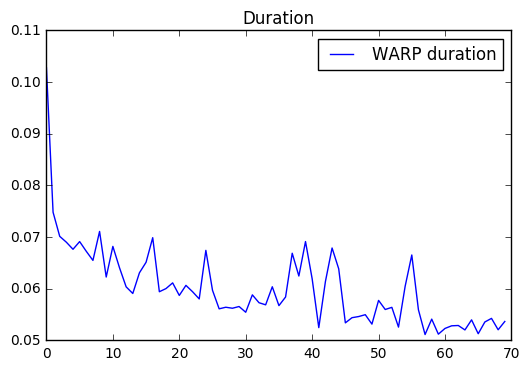

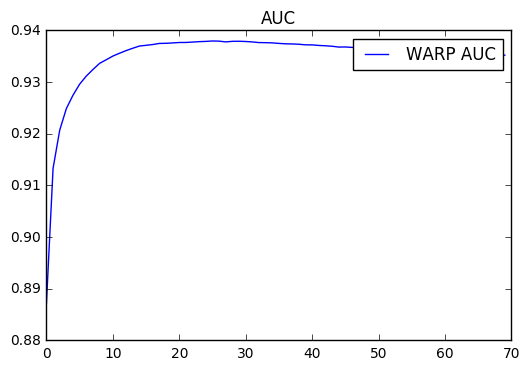

In [ ]:
warp_model = LightFM(no_components=num_components,
                     max_sampled=3,
                    loss='warp',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
warp_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.legend(['WARP duration'], loc='upper right')
plt.title('Duration')
plt.show()

x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP AUC'], loc='upper right')
plt.title('AUC')
plt.show()